In [28]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import pandas as pd
import Scripts.airfoil as af
import Scripts.fishUtilities as fu
import Scripts.fishFits as ff
import Scripts.surfaceAreaEstimators as sea
import Scripts.volumeEstimators as ve
import Scripts.cotEstimators as cot
import scipy.stats as st

from pathlib import Path
from scipy import stats
from scipy.optimize import curve_fit, minimize

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [29]:
# returns power law
def power_law(xData, a, b):
        return a * xData ** b

# method to fit data
def fit_data(xData, yData, ci):

    # Convert to percentile point of normal distribution
    pp = (1. + ci) / 2.

    # convert to number os standard deviations
    nstd = stats.norm.ppf(pp)

    # use the curve fit scipy function
    popt, pcov = curve_fit(power_law, xData, yData, p0=[1, 1])
    
    # standard deviation of parameters.  1 sigma error.
    perr = np.sqrt(np.diag(pcov))

    # Add nstd standard deviations to parameters to obtain the confidence
    # interval.
    popt_up = popt + nstd * perr
    popt_dwn = popt - nstd * perr

    # find the residuals between data and fit
    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, popt_up, popt_dwn, r_squared

In [30]:
def find_factor(data, calculated):
    # returns the factor in which the rms error is minimized
    def func(x):
        return np.sqrt(np.sum(np.abs((calculated/x) - data)**2)/len(data))

    res = minimize(func, 1.5, tol=1e-10)

    return res

In [31]:
imagePath = r'./Pictures'
figurePath = r'./Figures'

In [32]:
# Split work depending on input images
def process_top(imageList):
    # make a copy of the image
    topImage = imageList[0].copy()
    if(len(imageList) < 2):
        topImageFull = imageList[0].copy()
    else:
        topImageFull = imageList[1].copy()
    # get contours
    cntsTop, hullTop = fu.get_contours(topImage)
    cntsTopFull, hullTopFull = fu.get_contours(topImageFull)
    
    # Find the area ratio of fins and no fins
    areaTopFull = cv2.contourArea(cntsTopFull)
    areaTopNF = cv2.contourArea(cntsTop)
    areaRatioTop = (1-np.abs(areaTopNF/areaTopFull))

    # split the hull into top and bottom
    (cxTop, cyTop), topHullTop, bottomHullTop = fu.split_by_centroid_top(topImage.shape, cntsTop)
    (cxTopFull, cyTopFull), topHullTopFull, bottomHullTopFull = fu.split_by_centroid_top(topImageFull.shape, cntsTopFull)

    # scale contour data
    areaTop, tHullTop, bHullTop = fu.scale_data_top(topHullTop, bottomHullTop)
    areaTopFull, tHullTopFull, bHullTopFull = fu.scale_data_top(topHullTopFull, bottomHullTopFull)
    
    # get min and max points
    maxPointsTop, minPointsTop = fu.get_min_max(tHullTop, bHullTop)
    
    # fit data
    topPolyArea, topFitTop, bottomFitTop = ff.fit_top_contours_poly(tHullTop, bHullTop, 6)
    nacaArea, m, thickness, d0, xu, yu, xl, yl = ff.fit_top_contours(areaTop, np.mean([minPointsTop[0],maxPointsTop[0]]), np.abs(minPointsTop[1])+maxPointsTop[1], (tHullTop[1,-5]+np.abs(bHullTop[1,-5]))/2.0)
    
    return (areaRatioTop, [cntsTop, cntsTopFull], [maxPointsTop, minPointsTop],
            [topFitTop, bottomFitTop], [m, thickness, d0], [tHullTop, bHullTop])

In [33]:
def process_side(imageList):
    # make a copy of the image
    sideImage = imageList[0].copy()
    sideImageFull = imageList[1].copy()

    # get contours
    cntsSide, hullSide = fu.get_contours(sideImage)
    cntsSideFull, hullSideFull = fu.get_contours(sideImageFull)
    
    # Find the area ratio of fins and no fins
    areaSideFull = cv2.contourArea(cntsSideFull)
    areaSideNF = cv2.contourArea(cntsSide)
    areaRatioSide = (1-np.abs(areaSideNF/areaSideFull))
    
    (cxSide, cySide), areaSideNF, topHullSide, bottomHullSide = fu.split_by_centroid_side(sideImage.shape, cntsSide)
    (cxSideFull, cySideFull), areaSideFull, topHullSideFull, bottomHullSideFull = fu.split_by_centroid_side(sideImageFull.shape, cntsSideFull)

    # scale contour data
    scaleFactorSide, tHullSide, bHullSide = fu.scale_data(topHullSide, bottomHullSide)
    scaleFactorSideFull, tHullSideFull, bHullSideFull = fu.scale_data(topHullSideFull, bottomHullSideFull)
    
    # get min and max points
    maxPointsSide, minPointsSide = fu.get_min_max(tHullSide, bHullSide)
    
    #fit data
    topFitSide, bottomFitSide = ff.fit_side_contours(tHullSide, bHullSide, 6)
    
    return (areaRatioSide, [cntsSide, cntsSideFull], [maxPointsSide, minPointsSide], [topFitSide, bottomFitSide], [tHullSide, bHullSide])

Data for the scanned salmon

In [34]:
imagePathSide = fu.get_image_files(imagePath, 'scannedSalmonSideNF.png')
imagePathSideFull = fu.get_image_files(imagePath, 'scannedSalmonSide.png')

# import images
imageSide = cv2.imread(imagePathSide[0].as_posix())
imageSideFull = cv2.imread(imagePathSideFull[0].as_posix())


imagePathTop = fu.get_image_files(imagePath, 'scannedSalmonTopNF.png')
imagePathTopFull = fu.get_image_files(imagePath, 'scannedSalmonTop.png')

if(len(imagePathTopFull) == 0):
    imagePathTopFull = imagePathTop


# import images
imageTop = cv2.imread(imagePathTop[0].as_posix())
imageTopFull = cv2.imread(imagePathTopFull[0].as_posix())

# Salmon Data
sideArea_salmon, sideContours_salmon, sidePoints_salmon, sideFits_salmon, sideHull_salmon = process_side([imageSide, imageSideFull])

topArea_salmon, topContours_salmon, topPoints_salmon, topPolyFits_salmon, nacaFits_salmon, topHull_salmon = process_top([imageTop, imageTopFull])

Data for Altantic Cod

In [35]:
imagePathSide = fu.get_image_files(imagePath, 'atlanticCodSideNF.png')
imagePathSideFull = fu.get_image_files(imagePath, 'atlanticCodSide.png')

# import images
imageSide = cv2.imread(imagePathSide[0].as_posix())
imageSideFull = cv2.imread(imagePathSideFull[0].as_posix())


imagePathTop = fu.get_image_files(imagePath, 'atlanticCodTopNF.png')
imagePathTopFull = fu.get_image_files(imagePath, 'atlanticCodTop.png')

if(len(imagePathTopFull) == 0):
    imagePathTopFull = imagePathTop


# import images
imageTop = cv2.imread(imagePathTop[0].as_posix())
imageTopFull = cv2.imread(imagePathTopFull[0].as_posix())

# Atlantic Cod Data
sideArea_cod, sideContours_cod, sidePoints_cod, sideFits_cod, sideHull_cod = process_side([imageSide, imageSideFull])

topArea_cod, topContours_cod, topPoints_cod, topPolyFits_cod, nacaFits_cod, topHull_cod = process_top([imageTop, imageTopFull])

Data for Orca

In [36]:
imagePathSide = fu.get_image_files(imagePath, 'orcaSideNF.png')
imagePathSideFull = fu.get_image_files(imagePath, 'orcaSide.png')

# import images
imageSide = cv2.imread(imagePathSide[0].as_posix())
imageSideFull = cv2.imread(imagePathSideFull[0].as_posix())


imagePathTop = fu.get_image_files(imagePath, 'orcaTopNF.png')
imagePathTopFull = fu.get_image_files(imagePath, 'orcaTop.png')

if(len(imagePathTopFull) == 0):
    imagePathTopFull = imagePathTop


# import images
imageTop = cv2.imread(imagePathTop[0].as_posix())
imageTopFull = cv2.imread(imagePathTopFull[0].as_posix())

# Atlantic Cod Data
sideArea_orca, sideContours_orca, sidePoints_orca, sideFits_orca, sideHull_orca = process_side([imageSide, imageSideFull])

topArea_orca, topContours_orca, topPoints_orca, topPolyFits_orca, nacaFits_orca, topHull_orca = process_top([imageTop, imageTopFull])

Data for Silver Eel

In [37]:
imagePathSide = fu.get_image_files(imagePath, 'silverEelSideNF.png')
imagePathSideFull = fu.get_image_files(imagePath, 'silverEelSide.png')

# import images
imageSide = cv2.imread(imagePathSide[0].as_posix())
imageSideFull = cv2.imread(imagePathSideFull[0].as_posix())


imagePathTop = fu.get_image_files(imagePath, 'silverEelTopNF.png')
imagePathTopFull = fu.get_image_files(imagePath, 'silverEelTop.png')

if(len(imagePathTopFull) == 0):
    imagePathTopFull = imagePathTop


# import images
imageTop = cv2.imread(imagePathTop[0].as_posix())
imageTopFull = cv2.imread(imagePathTopFull[0].as_posix())

# Atlantic Cod Data
sideArea_silverEel, sideContours_silverEel, sidePoints_silverEel, sideFits_silverEel, sideHull_silverEel = process_side([imageSide, imageSideFull])

topArea_silverEel, topContours_silverEel, topPoints_silverEel, topPolyFits_silverEel, nacaFits_silverEel, topHull_silverEel = process_top([imageTop, imageTopFull])

In [38]:
scalingData = r'./osheaData.xlsx'

salmonDF = pd.read_excel(scalingData, sheet_name='Salmon')
salmon_length = salmonDF['Length [cm]'].values
salmon_area = salmonDF['SA [cm^2]'].values
salmon_mass = salmonDF['Mass [g]']

salmonDF = pd.read_excel(scalingData, sheet_name='Cod')
cod_length = salmonDF['Length [cm]'].values
cod_area = salmonDF['SA [cm^2]'].values
cod_mass = salmonDF['Mass [g]']

# convert from cm to meters
# area in m^2
# mass in kg
salmon_length = salmon_length / 100
salmon_area = salmon_area / 100**2
salmon_mass = salmon_mass / 1000

cod_length = cod_length / 100
cod_area = cod_area / 100**2
cod_mass = cod_mass / 1000

density = 1025

# Scanned Salmon Data
scanned_length = 0.397
scanned_area = 696.8288 / 100**2
scanned_volume = 823.6813 / 100**3

# Add to the salmon data
#salmon_length = np.append(salmon_length, scanned_length)
#salmon_area = np.append(salmon_area, scanned_area*0.9)

Just a note, the algorithm is written for standard length whereass the length-weight relationships are given as total length. Therefore, the length sent to the algorithm must be multiplied by a percentage of the total length to get the standard length. Standard length is assumed to be 90% of total length which is where the multiplication factor comes from.  For the case of the salmon, the data is for a different species so the length-weight correction factor is multiplied by the standard length conversion factor

Data for the salmon species

In [39]:
ika_salmon = np.zeros(len(salmon_length))
salmon_mass_lw = np.zeros(len(salmon_length))
salmon_mass_tri = np.zeros(len(salmon_length))

# length-weight relationship for salmon of the form a*length^b
lw_salmon = [0.0120, 2.99]

for idx, length in enumerate(salmon_length):
    volume, height, width = ve.determine_volume(1, 2, 0, length*0.855, sideFits_salmon[0], sideFits_salmon[1], nacaFits_salmon, nacaFits_salmon)
    ika_salmon[idx] = volume * density
    salmon_mass_lw[idx] = (lw_salmon[0]*(length*100)**lw_salmon[1])/1000
    salmon_mass_tri[idx] = (np.pi/6)*(length * height * width)*density

In [40]:
res = find_factor(salmon_mass_lw, ika_salmon)
salmonFactor = res.x[0]

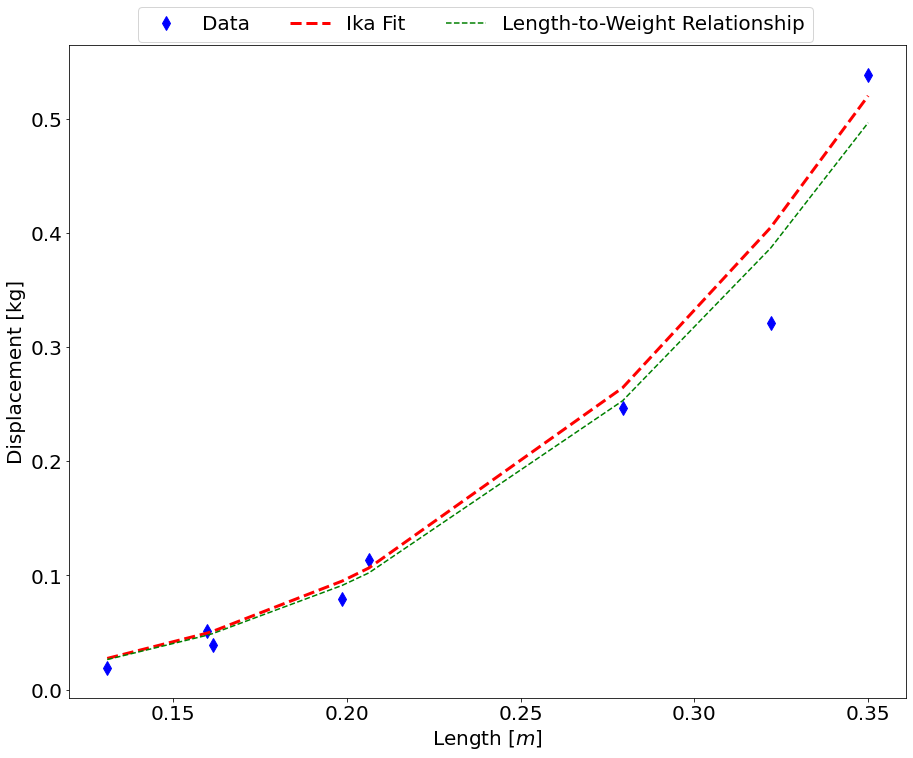

In [41]:
plt.rcParams.update({'font.size': 20, 'lines.markersize':10})

fig1, ax1 = plt.subplots(figsize=((15, 12)))
ax1.plot(salmon_length, salmon_mass, 'bd', label='Data')
ax1.plot(salmon_length, ika_salmon, 'r--', label="Ika Fit", linewidth=3)
#ax1.plot(salmon_length, ika_salmon/salmonFactor, 'rd:', label='Ika Fit w/ Factor', linewidth=3)
ax1.plot(salmon_length, salmon_mass_lw, 'g--', label='Length-to-Weight Relationship')
#ax1.plot(salmon_length, salmon_mass_tri, 'k:', label='PSM')
ax1.set_ylabel('Displacement [kg]')
ax1.set_xlabel('Length $[m]$')
ax1.legend(loc='best', ncol = 3, bbox_to_anchor=(0.9, 1.075))
fig1.savefig(Path(figurePath).joinpath('salmon_mass.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [42]:
error_ika = [np.sqrt(np.sum(np.abs(ika_salmon - salmon_mass)**2)/len(salmon_mass)), np.sum(np.abs(ika_salmon - salmon_mass))/len(salmon_mass)]
error_tri = [np.sqrt(np.sum(np.abs(salmon_mass_tri - salmon_mass)**2)/len(salmon_mass)), np.sum(np.abs(salmon_mass_tri - salmon_mass))/len(salmon_mass)]

print(error_ika, error_tri)

[0.03178654991403409, 0.02043580806347172] [0.09326907385840195, 0.06843921147860024]


Data for the Cod Species

In [43]:
ika_cod = np.zeros(len(cod_length))
cod_mass_lw = np.zeros(len(cod_length))
cod_mass_tri = np.zeros(len(cod_length))

# length-weight relationship for cod of the form a*length^b
lw_cod = [0.0069, 3.09]

for idx, length in enumerate(cod_length):
    volume, height, width = ve.determine_volume(1, 2, 0, length*0.90, sideFits_cod[0], sideFits_cod[1], nacaFits_cod, nacaFits_cod)
    ika_cod[idx] = volume * density
    cod_mass_lw[idx] = (lw_cod[0]*(length*100)**lw_cod[1])/1000

    cod_mass_tri[idx] = (np.pi/6)*(length * height * width)*density

In [44]:
res = find_factor(cod_mass_lw, ika_cod)
codFactor = res.x[0]

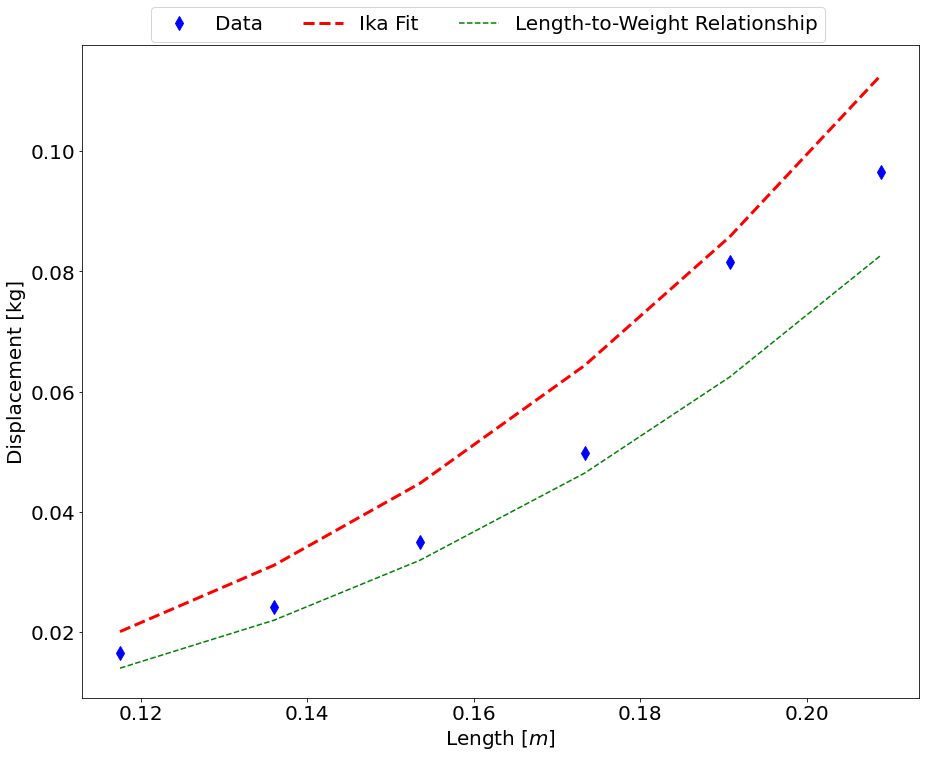

In [45]:
fig2, ax2 = plt.subplots(figsize=((15, 12)))
ax2.plot(cod_length, cod_mass, 'bd', label='Data')
ax2.plot(cod_length, ika_cod, 'r--', label="Ika Fit", linewidth=3)
#ax2.plot(cod_length, ika_cod/codFactor, 'rd:', label='Ika Fit w/ Factor', linewidth=3)
ax2.plot(cod_length, cod_mass_lw, 'g--', label='Length-to-Weight Relationship')
#ax2.plot(cod_length, cod_mass_tri, 'k:', label='PSM')
ax2.set_ylabel('Displacement [kg]')
ax2.set_xlabel('Length $[m]$')
ax2.legend(loc='best', ncol = 3, bbox_to_anchor=(0.9, 1.075))
fig2.savefig(Path(figurePath).joinpath('cod_mass.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [46]:
error_ika = [np.sqrt(np.sum(np.abs(ika_cod - cod_mass)**2)/len(cod_mass)), np.sum(np.abs(ika_cod - cod_mass))/len(cod_mass)]
error_tri = [np.sqrt(np.sum(np.abs(cod_mass_tri - cod_mass)**2)/len(cod_mass)), np.sum(np.abs(cod_mass_tri - cod_mass))/len(cod_mass)]

print(error_ika, error_tri)

[0.01036916987210339, 0.00916997419611528] [0.025750072257375252, 0.023244740345372387]


In [47]:
orca_length = np.linspace(3, 7, 10)
ika_orca = np.zeros(len(orca_length))
orca_mass_lw = np.zeros(len(orca_length))
orca_mass_tri = np.zeros(len(orca_length))

# length-weight relationship for cod of the form a*length^b
lw_orca = [6e-6, 3.2]

for idx, length in enumerate(orca_length):
    volume, height, width = ve.determine_volume(1, 2, 0, length*0.97, sideFits_orca[0], sideFits_orca[1], nacaFits_orca, nacaFits_orca)
    ika_orca[idx] = volume * density
    orca_mass_lw[idx] = (lw_orca[0]*(length*100)**lw_orca[1])

    orca_mass_tri[idx] = (np.pi/6)*(length * height * width)*density

In [48]:
res = find_factor(orca_mass_lw, ika_orca)
orcaFactor = res.x[0]

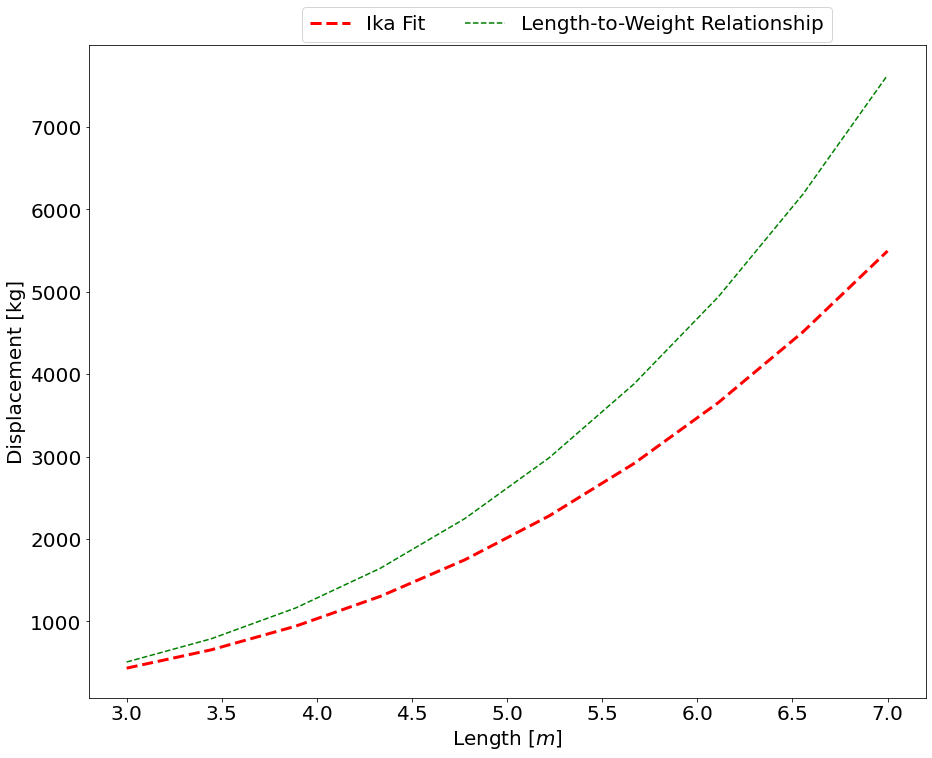

In [49]:
fig3, ax3 = plt.subplots(figsize=((15, 12)))
ax3.plot(orca_length, ika_orca, 'r--', label="Ika Fit", linewidth=3)
#ax3.plot(orca_length, ika_orca/orcaFactor, 'rd:', label='Ika Fit w/ Factor', linewidth=3)
ax3.plot(orca_length, orca_mass_lw, 'g--', label='Length-to-Weight Relationship')
#ax3.plot(orca_length, orca_mass_tri, 'k:', label='PSM')
ax3.set_ylabel('Displacement [kg]')
ax3.set_xlabel('Length $[m]$')
ax3.legend(loc='best', ncol = 2, bbox_to_anchor=(0.9, 1.075))
fig3.savefig(Path(figurePath).joinpath('orca_mass.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [50]:
error_ika = [np.sqrt(np.sum(np.abs(ika_orca - orca_mass_lw)**2)/len(orca_mass_lw)), np.sum(np.abs(ika_orca - orca_mass_lw))/len(orca_mass_lw)]
error_tri = [np.sqrt(np.sum(np.abs(orca_mass_tri - orca_mass_lw)**2)/len(orca_mass_lw)), np.sum(np.abs(orca_mass_tri - orca_mass_lw))/len(orca_mass_lw)]

print(error_ika, error_tri)

[1042.3349302308613, 803.055417877675] [652.0660323039575, 477.7747063069616]


In [51]:
silverEel_length = np.linspace(0.5, 3, 10)
ika_silverEel = np.zeros(len(silverEel_length))
silverEel_mass_lw = np.zeros(len(silverEel_length))
silverEel_mass_tri = np.zeros(len(silverEel_length))

# length-weight relationship for cod of the form a*length^b
lw_silverEel = [0.0006, 3.18]

for idx, length in enumerate(silverEel_length):
    volume, height, width = ve.determine_volume(1, 2, 0, length, sideFits_silverEel[0], sideFits_silverEel[1], nacaFits_silverEel, nacaFits_silverEel)
    ika_silverEel[idx] = volume * density
    silverEel_mass_lw[idx] = (lw_silverEel[0]*(length*100)**lw_silverEel[1])/1000

    silverEel_mass_tri[idx] = (np.pi/6)*(length * height * width)*density

In [52]:
res = find_factor(silverEel_mass_lw, ika_silverEel)
silverEelFactor = res.x[0]

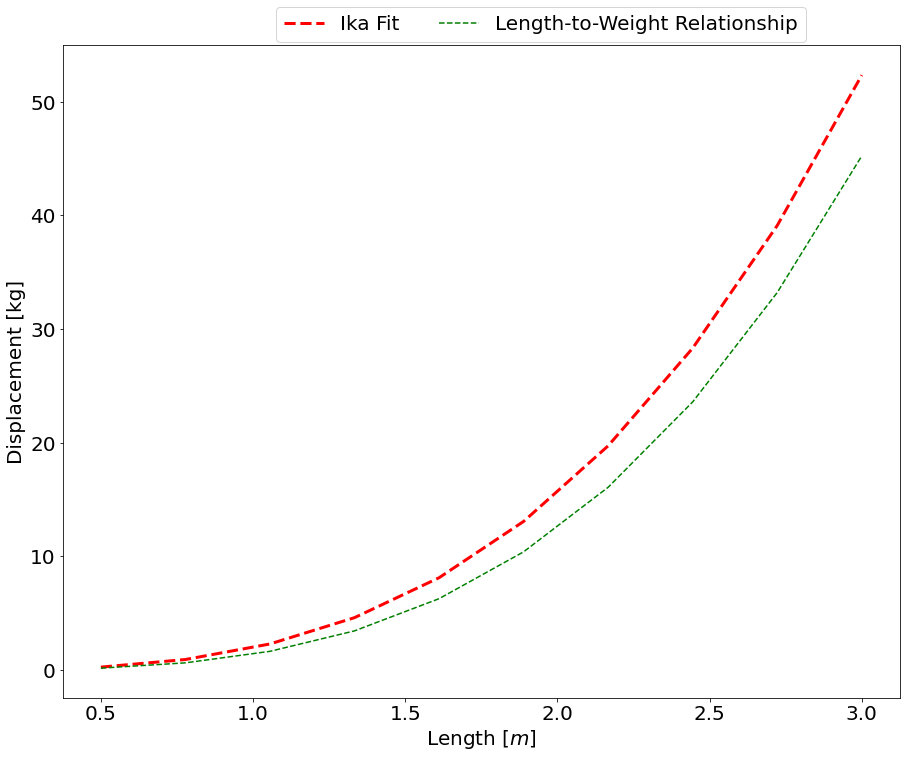

In [53]:
fig4, ax4 = plt.subplots(figsize=((15, 12)))
ax4.plot(silverEel_length, ika_silverEel, 'r--', label="Ika Fit", linewidth=3)
#ax4.plot(silverEel_length, ika_silverEel/silverEelFactor, 'rd:', label='Ika Fit w/ Factor', linewidth=3)
ax4.plot(silverEel_length, silverEel_mass_lw, 'g--', label='Length-to-Weight Relationship')
#ax4.plot(orca_length, orca_mass_tri, 'k:', label='PSM')
ax4.set_ylabel('Displacement [kg]')
ax4.set_xlabel('Length $[m]$')
ax4.legend(loc='best', ncol = 2, bbox_to_anchor=(0.9, 1.075))
fig4.savefig(Path(figurePath).joinpath('silverEel_mass.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [54]:
error_ika = [np.sqrt(np.sum(np.abs(ika_silverEel - silverEel_mass_lw)**2)/len(silverEel_mass_lw)), np.sum(np.abs(ika_silverEel - silverEel_mass_lw))/len(silverEel_mass_lw)]
error_tri = [np.sqrt(np.sum(np.abs(silverEel_mass_tri - silverEel_mass_lw)**2)/len(silverEel_mass_lw)), np.sum(np.abs(silverEel_mass_tri - silverEel_mass_lw))/len(silverEel_mass_lw)]

print(error_ika, error_tri)

[3.6534919403175325, 2.8104164876231126] [1.3793526161446694, 1.1649155550685641]
